# AI-Guided Technical Debt Reduction via XGBoost

**Research Question:** How Can AI Assist Software Developers in Automated Code Refactoring and Technical Debt Reduction?

**Focus:** Cyclomatic complexity reduction as a measurable, single-dimension debt metric.  
**Method:** XGBoost regressor predicts expected complexity improvement (delta); top-K budgeted refactoring selection vs. static baselines.  
**Dataset:** `code_smells_refactoring_dataset_120k.csv` (120,000 records, 18 features)

---

## Pipeline Overview

```
Input Code Metrics --> Feature Engineering --> XGBoost Prediction --> Refactoring Ranking --> Metric Evaluation --> Baseline Comparison
```

## 1. Environment Setup & Imports

In [1]:
# ============================================================
# Install (uncomment if needed in your environment)
# ============================================================
# !pip install xgboost scikit-learn pandas numpy matplotlib seaborn shap joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RandomizedSearchCV
)

import xgboost as xgb
from copy import deepcopy
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, mean_squared_error, r2_score
)
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 120

RANDOM_STATE = 42
print("Environment ready.")

Environment ready.


## 2. Data Loading & Initial Audit

In [2]:
# Adjust path to your local dataset location
DATA_PATH = "code_smells_refactoring_dataset_120k.csv"
df = pd.read_csv("/Users/gagan/code smell/code_smells_refactoring_dataset_120k.csv")


print(f"Dataset shape: {df.shape}")
print(f"Column dtypes:{df.dtypes}")
print(f"Missing values per column:{df.isnull().sum()[df.isnull().sum() > 0]}")
df.head(5)

Dataset shape: (120000, 18)
Column dtypes:project_id                      int64
file_name                      object
language                       object
framework                      object
lines_of_code                   int64
cyclomatic_complexity           int64
num_methods                     int64
num_classes                     int64
code_smell_type                object
smell_severity                 object
refactoring_suggested          object
refactoring_applied             int64
pre_refactor_complexity         int64
post_refactor_complexity        int64
technical_debt_minutes          int64
maintainability_index         float64
bug_prone_score               float64
developer_experience_years      int64
dtype: object
Missing values per column:framework    20200
dtype: int64


,project_id,file_name,language,framework,lines_of_code,cyclomatic_complexity,num_methods,num_classes,code_smell_type,smell_severity,refactoring_suggested,refactoring_applied,pre_refactor_complexity,post_refactor_complexity,technical_debt_minutes,maintainability_index,bug_prone_score,developer_experience_years
0,8270,file_0.py,C++,React,562,18,9,11,Shotgun Surgery,Major,Extract Method,0,27,13,65,45.53,0.734,4
1,1860,file_1.py,Go,Flask,715,8,36,5,Lazy Class,Minor,Rename Variable,0,46,10,38,47.63,0.470,5
2,6390,file_2.py,C#,Spring,1616,34,41,1,Feature Envy,Minor,Introduce Parameter Object,1,50,29,202,74.49,0.030,2
3,6191,file_3.py,JavaScript,Angular,386,20,57,1,Feature Envy,Major,Introduce Parameter Object,0,12,28,329,45.08,0.270,12
4,6734,file_4.py,C++,NaN,1478,27,38,5,Large Class,Minor,Extract Method,0,34,9,54,63.74,0.951,17


## 3. Exploratory Data Analysis (EDA)

We examine the distributions of key features, the target variable, and categorical breakdowns.

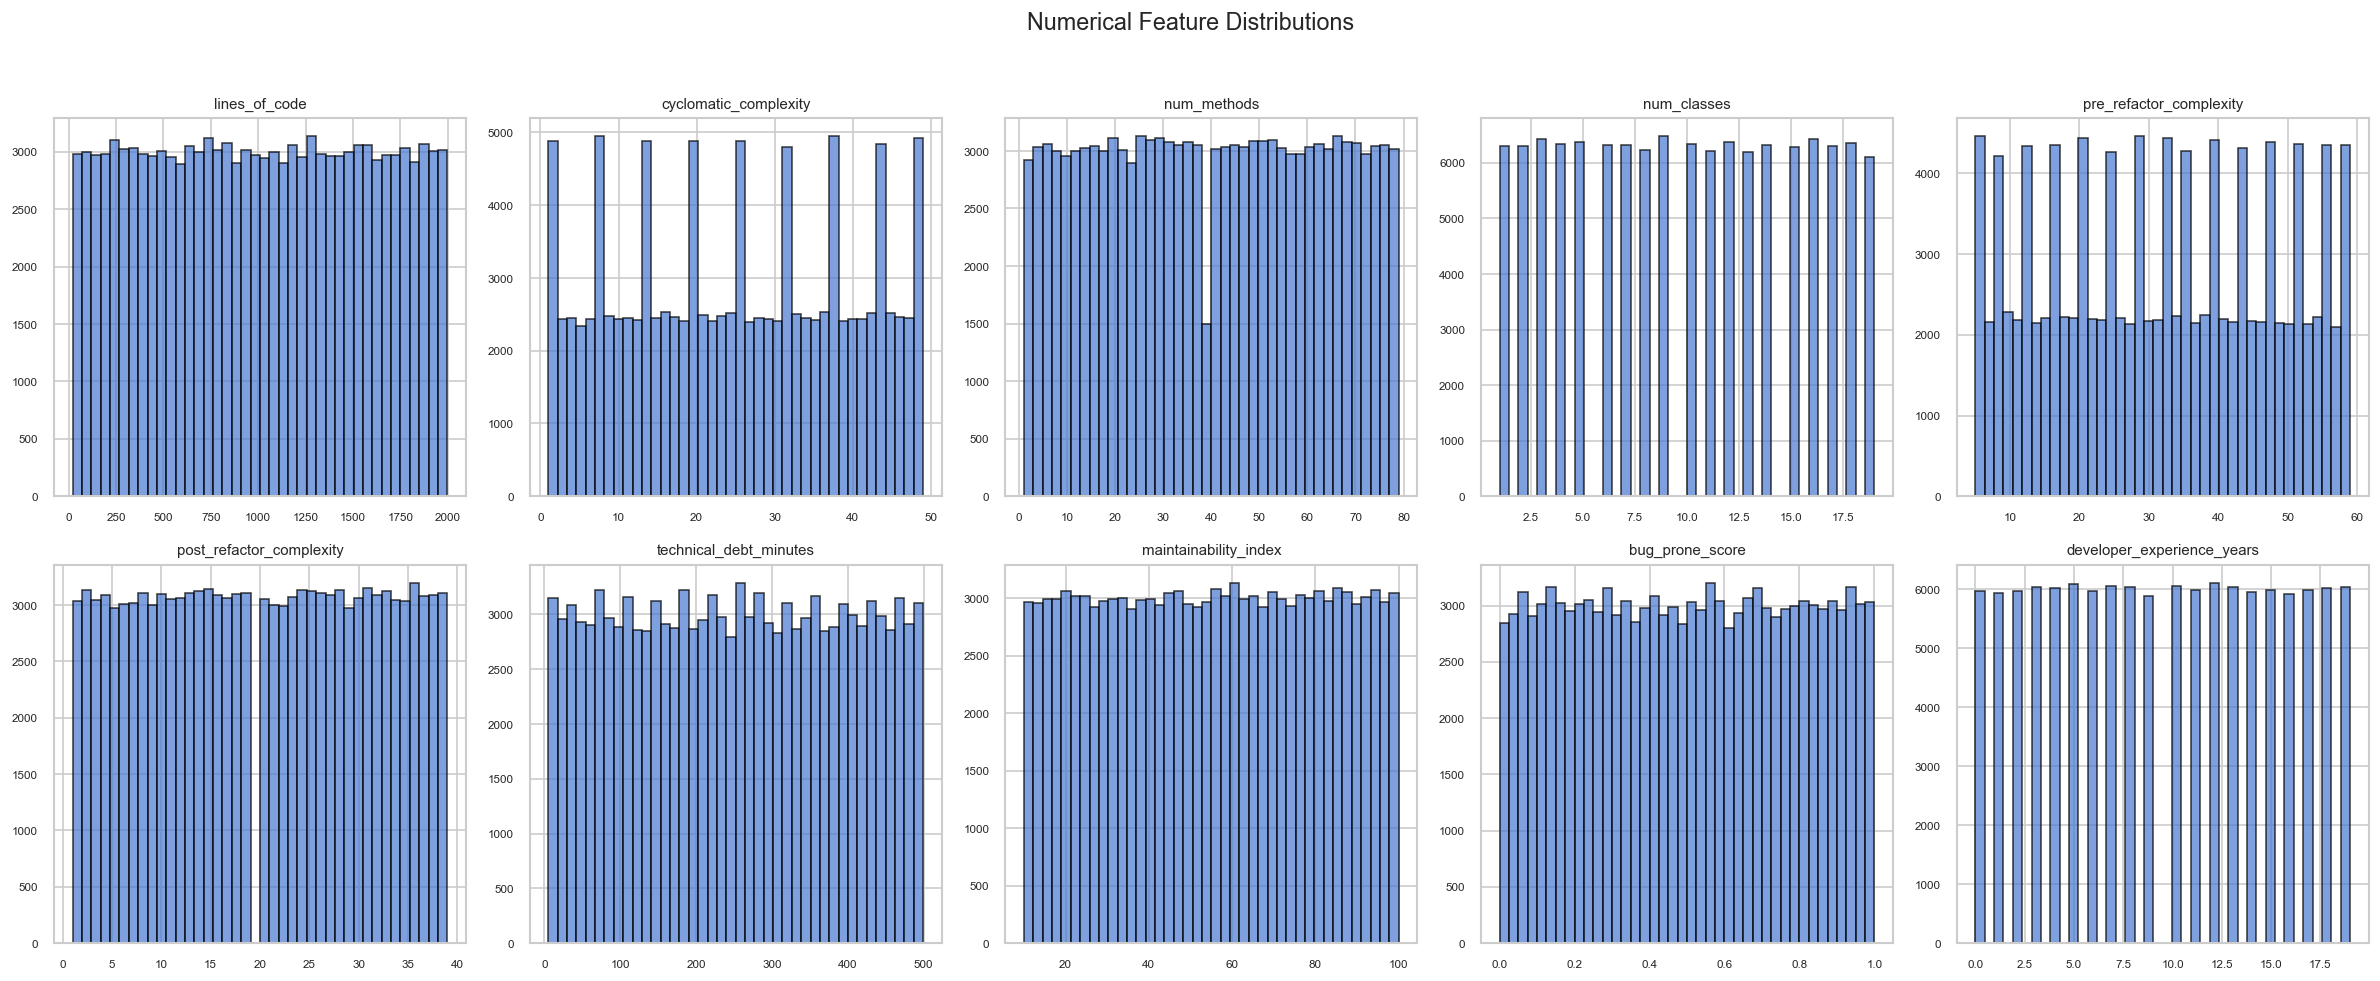

In [3]:
# --- 3a. Numerical feature distributions ---
num_cols = ["lines_of_code", "cyclomatic_complexity", "num_methods",
           "num_classes", "pre_refactor_complexity", "post_refactor_complexity",
           "technical_debt_minutes", "maintainability_index", "bug_prone_score",
           "developer_experience_years"]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, col in enumerate(num_cols):
    ax = axes[i // 5, i % 5]
    df[col].hist(bins=40, ax=ax, edgecolor="black", alpha=0.7)
    ax.set_title(col, fontsize=9)
    ax.tick_params(labelsize=7)
plt.suptitle("Numerical Feature Distributions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

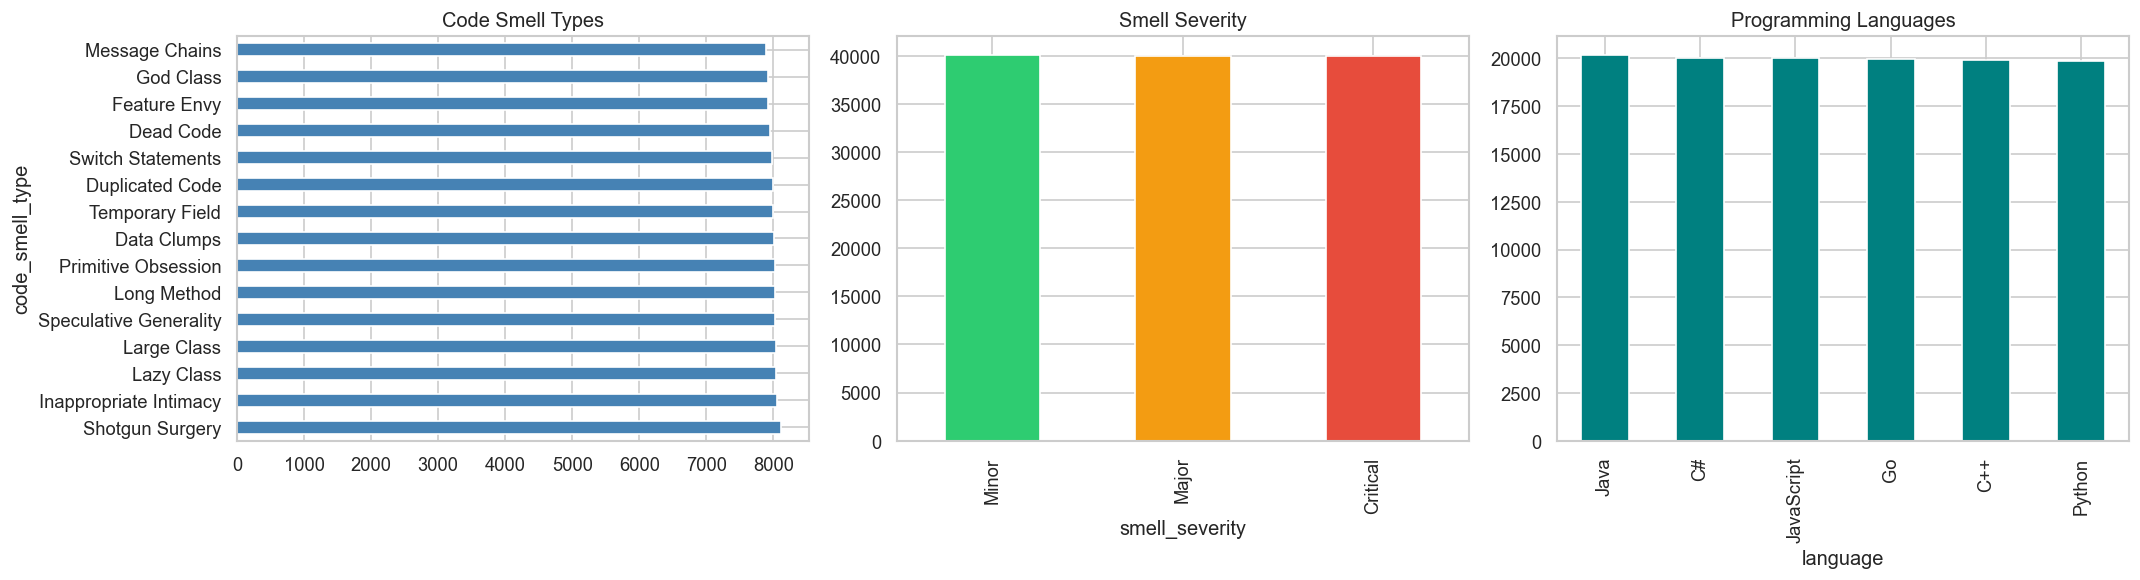

In [4]:
# --- 3b. Categorical distributions ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df["code_smell_type"].value_counts().plot.barh(ax=axes[0], color="steelblue")
axes[0].set_title("Code Smell Types")

df["smell_severity"].value_counts().plot.bar(ax=axes[1], color=["#2ecc71","#f39c12","#e74c3c"])
axes[1].set_title("Smell Severity")

df["language"].value_counts().plot.bar(ax=axes[2], color="teal")
axes[2].set_title("Programming Languages")

plt.tight_layout()
plt.show()

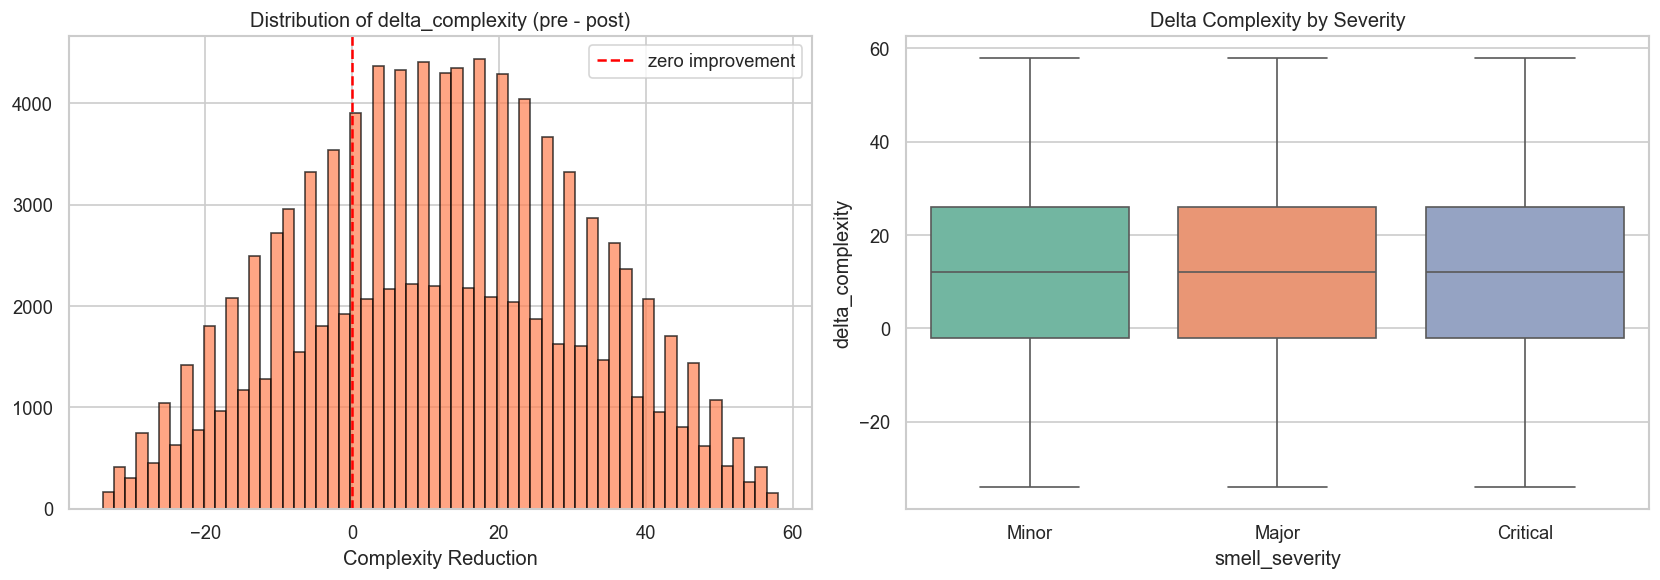

delta_complexity stats:count    120000.000000
mean         11.898533
std          19.485569
min         -34.000000
25%          -2.000000
50%          12.000000
75%          26.000000
max          58.000000
Name: delta_complexity, dtype: float64
Negative (worsened): 33,524 (27.9%)
Positive (improved): 84,564 (70.5%)


In [5]:
# --- 3c. Target variable: delta_complexity ---
df["delta_complexity"] = df["pre_refactor_complexity"] - df["post_refactor_complexity"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df["delta_complexity"].hist(bins=60, ax=axes[0], edgecolor="black", alpha=0.7, color="coral")
axes[0].axvline(x=0, color="red", linestyle="--", linewidth=1.5, label="zero improvement")
axes[0].set_title("Distribution of delta_complexity (pre - post)")
axes[0].set_xlabel("Complexity Reduction")
axes[0].legend()

sns.boxplot(data=df, x="smell_severity", y="delta_complexity",
            order=["Minor", "Major", "Critical"], ax=axes[1], palette="Set2")
axes[1].set_title("Delta Complexity by Severity")

plt.tight_layout()
plt.show()

print(f"delta_complexity stats:{df['delta_complexity'].describe()}")
print(f"Negative (worsened): {(df['delta_complexity'] < 0).sum():,} ({(df['delta_complexity'] < 0).mean()*100:.1f}%)")
print(f"Positive (improved): {(df['delta_complexity'] > 0).sum():,} ({(df['delta_complexity'] > 0).mean()*100:.1f}%)")

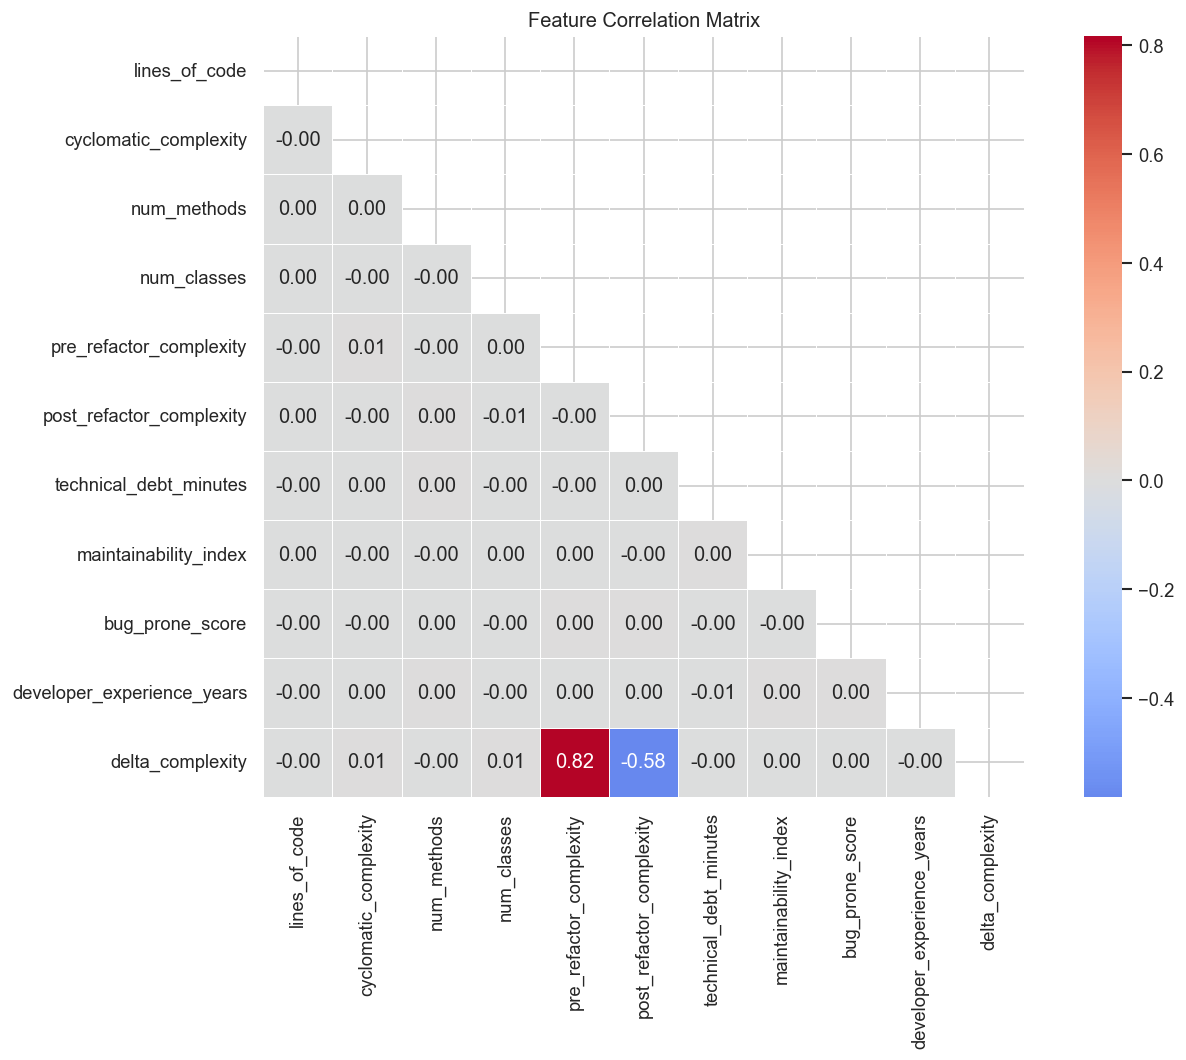

Correlation with delta_complexity:
delta_complexity              1.000000
pre_refactor_complexity       0.816434
cyclomatic_complexity         0.006157
num_classes                   0.005805
maintainability_index         0.002878
bug_prone_score               0.001158
developer_experience_years   -0.001200
technical_debt_minutes       -0.001726
lines_of_code                -0.002897
num_methods                  -0.003418
post_refactor_complexity     -0.581130


In [6]:
# --- 3d. Correlation heatmap (numeric features + target) ---
corr_cols = num_cols + ["delta_complexity"]
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(12, 9))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f",
            cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

print("Correlation with delta_complexity:")
print(corr_matrix["delta_complexity"].sort_values(ascending=False).to_string())

## 4. Technical Debt Definition & Feature Engineering

### Definition of Technical Debt in This Study

We focus on **cyclomatic complexity** as the single, measurable dimension of technical debt:

- **Metric:** 
- **Interpretation:** Positive values = complexity was reduced (debt repaid); negative = complexity increased
- **Efficiency:**  — complexity reduction normalized by code size

This aligns with the professor's requirement: *"clearly define what counts as technical debt"* and *"measurable improvement."*

In [7]:
# --- 4a. Feature engineering ---
df = df.copy()

# Target: complexity reduction
df["delta_complexity"] = df["pre_refactor_complexity"] - df["post_refactor_complexity"]

# Efficiency: how much reduction per 10 LOC (normalized impact)
df["refactor_efficiency"] = df["delta_complexity"] / (df["lines_of_code"].replace(0, np.nan) / 10.0)
df["refactor_efficiency"] = df["refactor_efficiency"].clip(lower=-50, upper=50)

# Derived features for richer signal
df["methods_per_class"] = df["num_methods"] / df["num_classes"].replace(0, 1)
df["loc_per_method"] = df["lines_of_code"] / df["num_methods"].replace(0, 1)
df["complexity_density"] = df["cyclomatic_complexity"] / (df["lines_of_code"].replace(0, 1) / 100.0)
df["debt_per_loc"] = df["technical_debt_minutes"] / df["lines_of_code"].replace(0, 1)

# Handle missing framework values (fill with "Unknown")
df["framework"] = df["framework"].fillna("Unknown")

# Clip target for robustness
df["delta_complexity"] = df["delta_complexity"].clip(lower=-200, upper=200)

print("Engineered features added.")
print(f"delta_complexity: mean={df['delta_complexity'].mean():.2f}, std={df['delta_complexity'].std():.2f}")
print(f"refactor_efficiency: mean={df['refactor_efficiency'].mean():.2f}, std={df['refactor_efficiency'].std():.2f}")

Engineered features added.
delta_complexity: mean=11.90, std=19.49
refactor_efficiency: mean=0.28, std=1.11


## 5. Feature Selection & Train/Test Split

**Data leakage prevention:** We exclude  from features — it is part of the target.  
 is kept as a legitimate input (the current state of the code before refactoring).

In [8]:
# --- 5a. Define features and targets ---
target_reg = "delta_complexity"       # Main regression target
target_cls = "code_smell_type"        # Classification target (diagnostic)

# Feature columns — NO post_refactor_complexity (leakage)
feature_cols = [
    "language", "framework",
    "lines_of_code", "cyclomatic_complexity", "num_methods", "num_classes",
    "smell_severity",
    "technical_debt_minutes",
    "maintainability_index",
    "bug_prone_score",
    "developer_experience_years",
    "pre_refactor_complexity",
    "methods_per_class",
    "loc_per_method",
    "complexity_density",
    "debt_per_loc",
]

# Verify all columns exist
feature_cols = [c for c in feature_cols if c in df.columns]
print(f"Using {len(feature_cols)} features: {feature_cols}")

# Drop any remaining NaN rows
model_df = df.dropna(subset=feature_cols + [target_reg, target_cls]).copy()
print(f"Model dataframe shape after dropna: {model_df.shape}")

X = model_df[feature_cols]
y_reg = model_df[target_reg]

# IMPORTANT: XGBClassifier expects integer-encoded labels, not strings.
# We use LabelEncoder and store the mapping for decoding predictions later.
le = LabelEncoder()
y_cls = le.fit_transform(model_df[target_cls])
y_cls = pd.Series(y_cls, index=model_df.index)   # keep aligned index

print(f"\nLabel encoding mapping:")
for i, name in enumerate(le.classes_):
    print(f"  {i} -> {name}")


Using 16 features: ['language', 'framework', 'lines_of_code', 'cyclomatic_complexity', 'num_methods', 'num_classes', 'smell_severity', 'technical_debt_minutes', 'maintainability_index', 'bug_prone_score', 'developer_experience_years', 'pre_refactor_complexity', 'methods_per_class', 'loc_per_method', 'complexity_density', 'debt_per_loc']
Model dataframe shape after dropna: (120000, 24)

Label encoding mapping:
  0 -> Data Clumps
  1 -> Dead Code
  2 -> Duplicated Code
  3 -> Feature Envy
  4 -> God Class
  5 -> Inappropriate Intimacy
  6 -> Large Class
  7 -> Lazy Class
  8 -> Long Method
  9 -> Message Chains
  10 -> Primitive Obsession
  11 -> Shotgun Surgery
  12 -> Speculative Generality
  13 -> Switch Statements
  14 -> Temporary Field


In [9]:
# --- 5b. Stratified train/test split (80/20) ---
X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    X, y_reg, y_cls,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y_cls   # preserve code smell distribution
)

print(f"Training set: {X_train.shape}")
print(f"Test set:     {X_test.shape}")
print(f"Target (regression) - Train mean: {y_reg_train.mean():.2f}, Test mean: {y_reg_test.mean():.2f}")
print(f"Classifier labels are integer-encoded (0..{y_cls_train.max()})")


Training set: (96000, 16)
Test set:     (24000, 16)
Target (regression) - Train mean: 11.89, Test mean: 11.91
Classifier labels are integer-encoded (0..14)


## 6. Preprocessing Pipeline

In [10]:
# Identify categorical vs numeric columns
categorical_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
numeric_cols = [c for c in X_train.columns if c not in categorical_cols]

print(f"Categorical ({len(categorical_cols)}): {categorical_cols}")
print(f"Numeric ({len(numeric_cols)}): {numeric_cols}")

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

Categorical (3): ['language', 'framework', 'smell_severity']
Numeric (13): ['lines_of_code', 'cyclomatic_complexity', 'num_methods', 'num_classes', 'technical_debt_minutes', 'maintainability_index', 'bug_prone_score', 'developer_experience_years', 'pre_refactor_complexity', 'methods_per_class', 'loc_per_method', 'complexity_density', 'debt_per_loc']


## 7. Model A — XGBoost Regressor: Predict Complexity Reduction

This is the **main contribution model.** It predicts how much complexity reduction ()  
a given code unit will achieve from refactoring. This prediction is then used to **rank and prioritize**  
which files to refactor under a fixed budget (top-K selection).

**Hyperparameter tuning:** RandomizedSearchCV with 5-fold cross-validation, scored on negative MAE.

In [11]:
xgb_reg = XGBRegressor(
    objective="reg:pseudohubererror",
    eval_metric="mae",
    tree_method="hist",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)

reg_pipeline = Pipeline(steps=[
    ("prep", preprocess),
    ("model", xgb_reg)
])

reg_param_dist = {
    "model__n_estimators":     [300, 500, 800],
    "model__learning_rate":    [0.03, 0.05, 0.1],
    "model__max_depth":        [3, 4, 5, 6],
    "model__min_child_weight": [1, 3, 5],
    "model__subsample":        [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__reg_alpha":        [0, 0.1, 1.0],
    "model__reg_lambda":       [1, 5, 10],
    "model__gamma":            [0, 1, 2],
}

reg_search = RandomizedSearchCV(
    reg_pipeline,
    param_distributions=reg_param_dist,
    n_iter=12,                 
    scoring="neg_mean_absolute_error",
    cv=3,                      
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=-1                  
)

print("Starting regressor hyperparameter search (12 iterations x 3 folds)...")
reg_search.fit(X_train, y_reg_train)

print("Best parameters:", reg_search.best_params_)
print(f"Best CV MAE: {-reg_search.best_score_:.4f}")
best_reg_model = reg_search.best_estimator_

Starting regressor hyperparameter search (12 iterations x 3 folds)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=10, model__subsample=0.8; total time=   3.3s
[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=10, model__subsample=0.8; total time=   3.2s
[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=10, model__subsample=0.8; total time=   3.3s
[CV] END model__colsample_bytree=0.8, model__gamma=2, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=1, model__n_estimators=300, model_

In [12]:


# -------------------------------
# Early stopping using native xgb.train (works on older xgboost sklearn wrappers)
# -------------------------------

# 1) Train/val split from training data
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_reg_train, test_size=0.15, random_state=RANDOM_STATE
)

# 2) Fit preprocessing ONCE
prep_final = deepcopy(preprocess)
X_tr_t  = prep_final.fit_transform(X_tr)
X_val_t = prep_final.transform(X_val)
X_test_t = prep_final.transform(X_test)

# 3) Convert to DMatrix
dtrain = xgb.DMatrix(X_tr_t, label=y_tr.values if hasattr(y_tr, "values") else y_tr)
dval   = xgb.DMatrix(X_val_t, label=y_val.values if hasattr(y_val, "values") else y_val)
dtest  = xgb.DMatrix(X_test_t)

# 4) Pull best params from your search and convert names to native xgb params
best_reg_params = {k.replace("model__", ""): v for k, v in reg_search.best_params_.items()}

# Map sklearn-style params to native xgb params
native_params = {
    "objective": "reg:pseudohubererror",   # robust regression
    "eval_metric": "mae",
    "tree_method": "hist",
    "seed": RANDOM_STATE,
    "eta": best_reg_params.get("learning_rate", 0.05),
    "max_depth": best_reg_params.get("max_depth", 5),
    "min_child_weight": best_reg_params.get("min_child_weight", 3),
    "subsample": best_reg_params.get("subsample", 1.0),
    "colsample_bytree": best_reg_params.get("colsample_bytree", 1.0),
    "alpha": best_reg_params.get("reg_alpha", 0.0),
    "lambda": best_reg_params.get("reg_lambda", 1.0),
    "gamma": best_reg_params.get("gamma", 0.0),
}

# 5) Train with early stopping
# Give it a big num_boost_round; ES will stop early
num_boost_round = max(800, int(best_reg_params.get("n_estimators", 300)))
evals = [(dtrain, "train"), (dval, "val")]

booster = xgb.train(
    params=native_params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False
)

print("Best iteration (native early stopping):", booster.best_iteration)

# 6) Predict on test using best iteration
y_reg_pred = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))

# 7) Metrics
mae = mean_absolute_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
r2 = r2_score(y_reg_test, y_reg_pred)

print("=" * 50)
print("REGRESSOR TEST SET PERFORMANCE (native early stopping)")
print("=" * 50)
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print("=" * 50)

Best iteration (native early stopping): 105
REGRESSOR TEST SET PERFORMANCE (native early stopping)
MAE  : 9.7168
RMSE : 11.2325
R²   : 0.6676


In [13]:
# Save booster + preprocess
booster.save_model("xgb_reg_booster.json")
joblib.dump(prep_final, "xgb_preprocess.joblib")

print("Saved: xgb_reg_booster.json and xgb_preprocess.joblib")

Saved: xgb_reg_booster.json and xgb_preprocess.joblib


## 8. Feature Importance Analysis (Regressor)

Understanding *which features drive the model's predictions* is critical for  
explaining to developers **why** certain files are prioritized for refactoring.

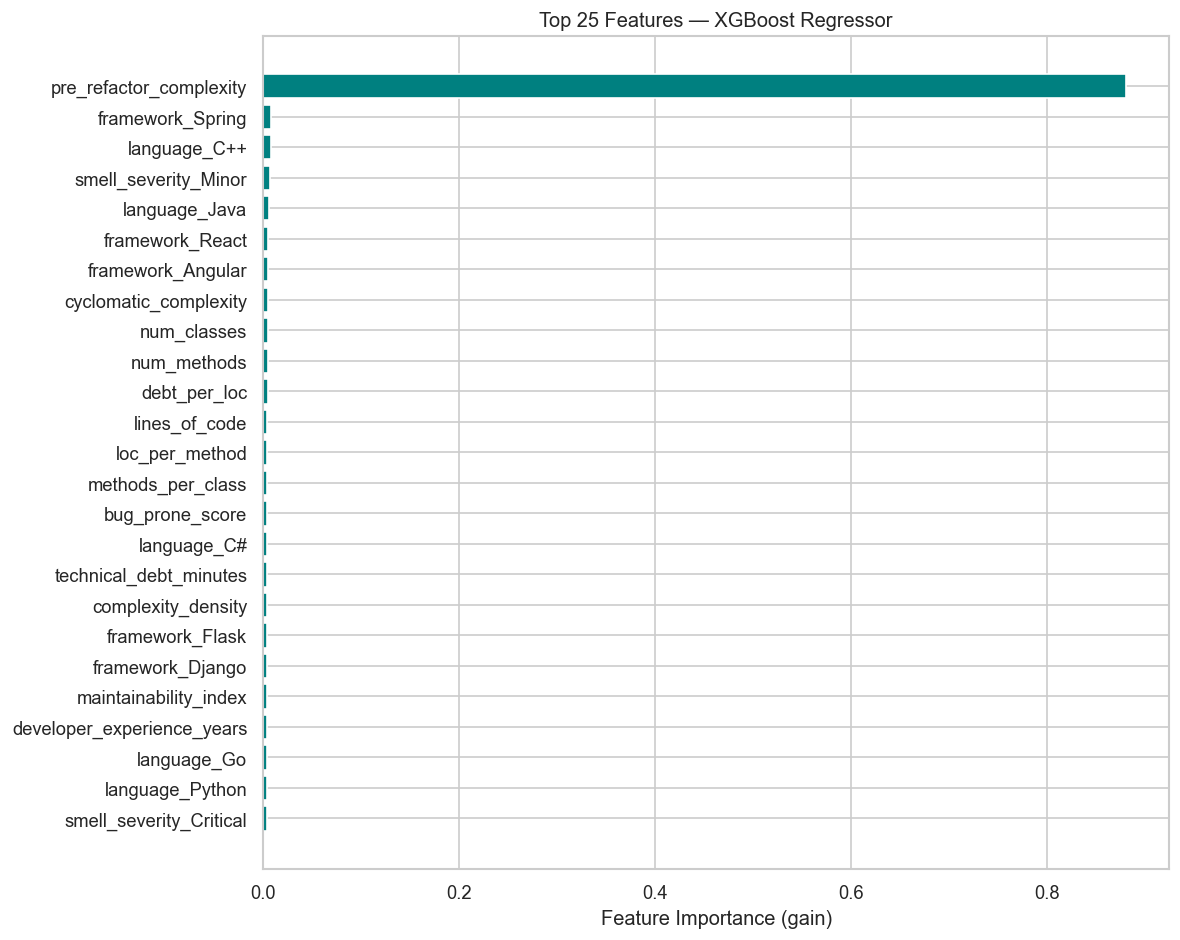

In [14]:
# --- 8a. XGBoost built-in feature importance ---
# Extract feature names after preprocessing
cat_feature_names = best_reg_model.named_steps["prep"].transformers_[0][1].get_feature_names_out(categorical_cols).tolist()
all_feature_names = cat_feature_names + numeric_cols

importances = best_reg_model.named_steps["model"].feature_importances_
feat_imp_df = pd.DataFrame({"feature": all_feature_names, "importance": importances})
feat_imp_df = feat_imp_df.sort_values("importance", ascending=False).head(25)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df["feature"][::-1], feat_imp_df["importance"][::-1], color="teal")
plt.xlabel("Feature Importance (gain)")
plt.title("Top 25 Features — XGBoost Regressor")
plt.tight_layout()
plt.show()

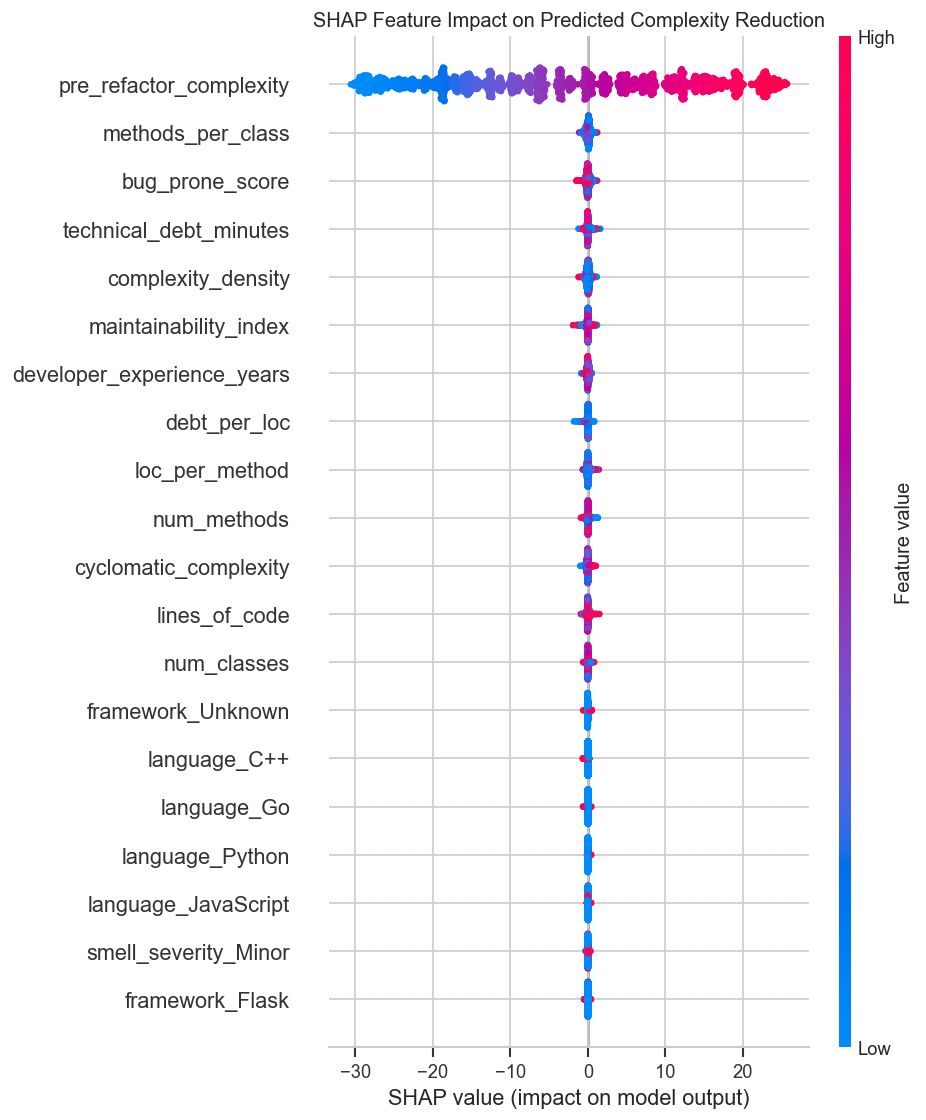

SHAP analysis complete.


In [15]:
# --- 8b. SHAP analysis (if shap is installed) ---
try:
    import shap
    
    # Prepare transformed data for SHAP
    X_test_transformed = best_reg_model.named_steps["prep"].transform(X_test)
    X_test_shap = pd.DataFrame(X_test_transformed, columns=all_feature_names)
    
    explainer = shap.TreeExplainer(best_reg_model.named_steps["model"])
    shap_values = explainer.shap_values(X_test_shap.iloc[:2000])  # subsample for speed
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_shap.iloc[:2000], max_display=20, show=False)
    plt.title("SHAP Feature Impact on Predicted Complexity Reduction")
    plt.tight_layout()
    plt.show()
    
    print("SHAP analysis complete.")
except ImportError:
    print("shap not installed — skipping SHAP analysis.")
    print("Install with: pip install shap")

## 9. Model B — XGBoost Classifier: Diagnose Code Smell Type

This supporting model classifies the **type** of code smell, providing diagnostic  
interpretability. Developers can see not just *how much* improvement is expected,  
but *what kind* of problem exists.

In [16]:
# --- 9a. Build classifier pipeline (CPU + tabular preprocessing) ---
from xgboost import XGBClassifier

num_classes = len(le.classes_)
print(f"Number of code smell classes: {num_classes}")

# CPU-friendly XGBoost classifier
xgb_clf = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",     
    random_state=RANDOM_STATE,
    n_jobs=-1,              
    verbosity=0
)

clf_pipeline = Pipeline(steps=[
    ("prep", preprocess),   
    ("model", xgb_clf)
])

clf_param_dist = {
    "model__n_estimators":     [300, 500, 800],
    "model__learning_rate":    [0.03, 0.05, 0.1],
    "model__max_depth":        [3, 4, 5, 6],
    "model__min_child_weight": [1, 3, 5],
    "model__subsample":        [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__reg_alpha":        [0, 0.1, 1.0],
    "model__reg_lambda":       [1, 5, 10],
    "model__gamma":            [0, 1, 2],
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

clf_search = RandomizedSearchCV(
    clf_pipeline,
    param_distributions=clf_param_dist,
    n_iter=12,              
    cv=skf,
    scoring="f1_macro",
    verbose=2,
    n_jobs=-1,              
    random_state=RANDOM_STATE
)

print("Starting classifier hyperparameter search (CPU)...")
clf_search.fit(X_train, y_cls_train)

print(f"\nBest parameters: {clf_search.best_params_}")
print(f"Best CV Macro-F1: {clf_search.best_score_:.4f}")
best_clf_model = clf_search.best_estimator_

Number of code smell classes: 15
Starting classifier hyperparameter search (CPU)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=10, model__subsample=0.8; total time= 1.1min
[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=10, model__subsample=0.8; total time= 1.1min
[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=10, model__subsample=0.8; total time= 1.1min
[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=5, model__n_estimato

CLASSIFICATION REPORT (Test Set)
                        precision    recall  f1-score   support

           Data Clumps     0.0670    0.0693    0.0682      1601
             Dead Code     0.0641    0.0572    0.0604      1591
       Duplicated Code     0.0648    0.0688    0.0667      1599
          Feature Envy     0.0704    0.0612    0.0655      1585
             God Class     0.0621    0.0701    0.0658      1584
Inappropriate Intimacy     0.0599    0.0552    0.0575      1612
           Large Class     0.0696    0.0796    0.0743      1608
            Lazy Class     0.0659    0.0646    0.0653      1609
           Long Method     0.0660    0.0648    0.0654      1605
        Message Chains     0.0687    0.0722    0.0704      1579
   Primitive Obsession     0.0707    0.0586    0.0641      1604
       Shotgun Surgery     0.0592    0.0702    0.0642      1623
Speculative Generality     0.0726    0.0773    0.0748      1605
     Switch Statements     0.0636    0.0583    0.0608      1596
      

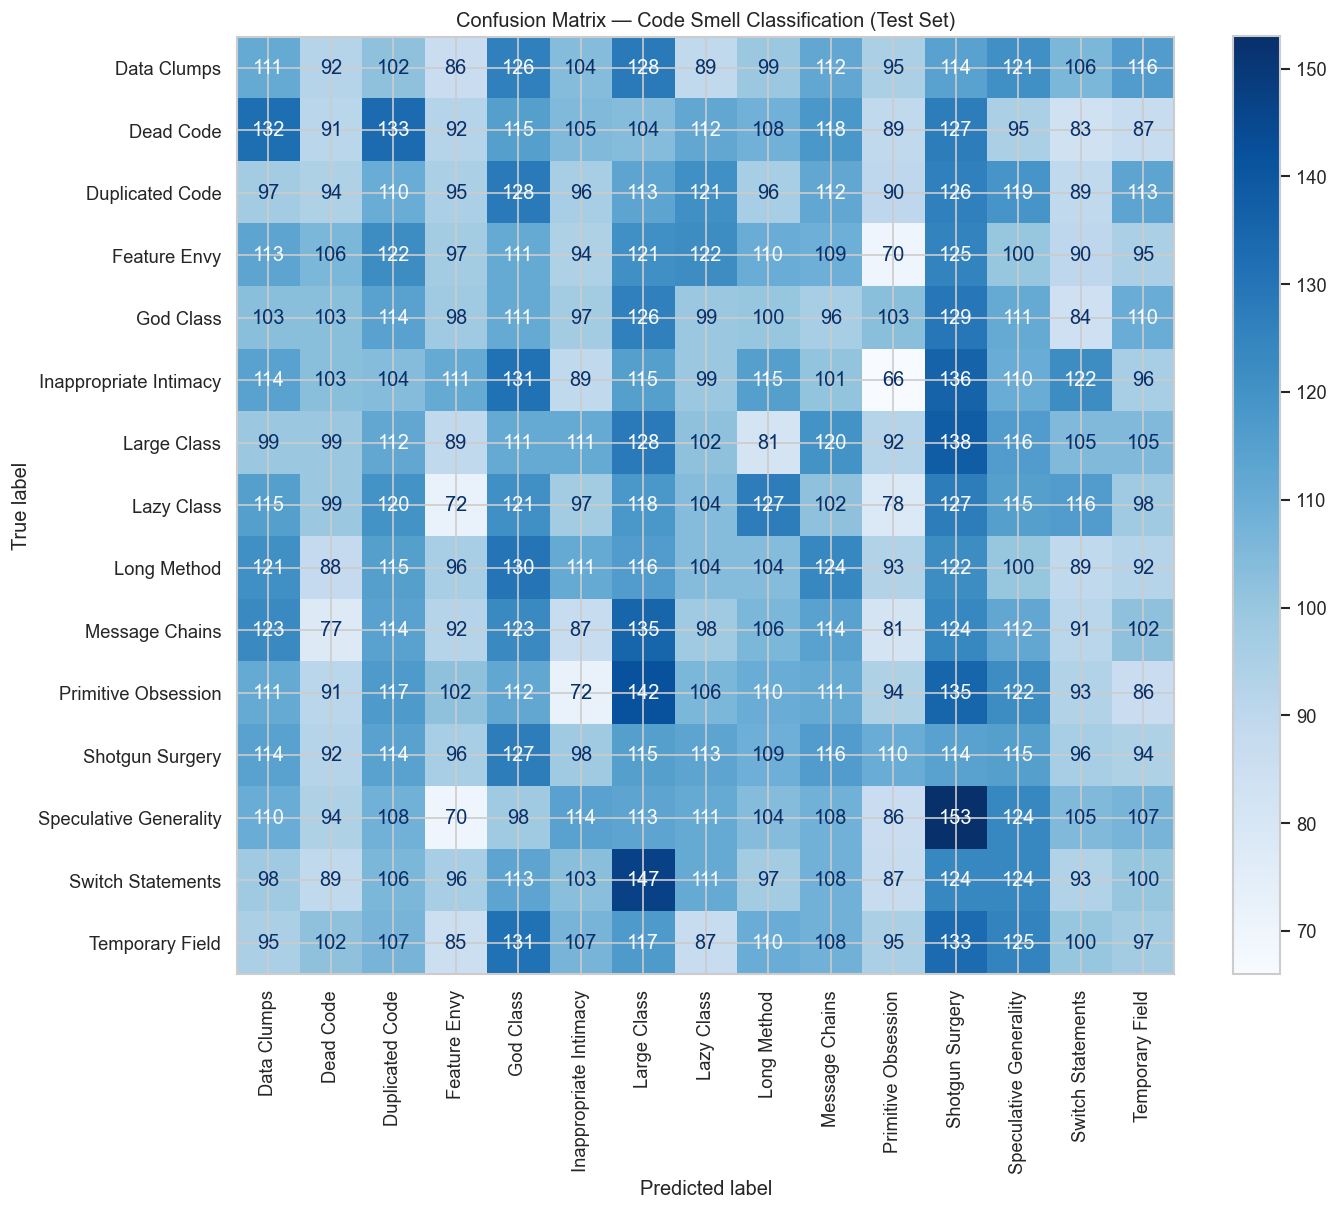

In [17]:
# --- 9b. Evaluate classifier on TEST set ---
y_cls_pred = best_clf_model.predict(X_test)

# Decode integer predictions back to original smell names for readable output
y_cls_test_labels = le.inverse_transform(y_cls_test)
y_cls_pred_labels = le.inverse_transform(y_cls_pred)

print("CLASSIFICATION REPORT (Test Set)")
print("=" * 60)
print(classification_report(y_cls_test_labels, y_cls_pred_labels, digits=4))

# Confusion matrix
labels = sorted(le.classes_)
cm = confusion_matrix(y_cls_test_labels, y_cls_pred_labels, labels=labels)

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, xticks_rotation=90, values_format="d", cmap="Blues")
ax.set_title("Confusion Matrix — Code Smell Classification (Test Set)")
plt.tight_layout()
plt.show()


## 10. Baseline Comparison — AI vs. Static Heuristics

This is the **core evaluation** that addresses the professor's requirement:  
*"AI can objectively reduce technical debt, not just rewrite code differently."*

We compare three refactoring prioritization strategies under a **fixed budget** (top-K files):

| Strategy | Selection Criterion |
|----------|--------------------|
| **Baseline 1: Static Rule** | CC > 10 or LOC > 80, ranked by CC |
| **Baseline 2: Debt Minutes** | Top-K by  |
| **AI Method (Ours)** | Top-K by predicted  |

**Metric:** Realized average  of the selected files (higher = better).

In [18]:
# --- 10a. Setup evaluation dataframe ---
test_df = X_test.copy()
test_df["true_delta_complexity"] = y_reg_test.values
test_df["pred_delta_complexity"] = y_reg_pred

# Budget: refactor top 10% of files
K = int(0.10 * len(test_df))
print(f"Refactoring budget: top K = {K} files (10% of test set)")

# --- 10b. Define evaluation function ---
def evaluate_topk(df_in, score_col, k, ascending=False):
    """Select top-K files by score_col and measure realized improvement."""
    selected = df_in.sort_values(score_col, ascending=ascending).head(k)
    return {
        "avg_delta": selected["true_delta_complexity"].mean(),
        "sum_delta": selected["true_delta_complexity"].sum(),
        "median_delta": selected["true_delta_complexity"].median(),
        "pct_positive": (selected["true_delta_complexity"] > 0).mean() * 100,
        "k": k
    }

# --- 10c. AI method ---
ai_result = evaluate_topk(test_df, "pred_delta_complexity", K)

# --- 10d. Baseline 2: Debt minutes ---
debt_result = evaluate_topk(test_df, "technical_debt_minutes", K)

# --- 10e. Baseline 1: Static rule (CC > 10 or LOC > 80) ---
CC_THRESHOLD = 10
LOC_THRESHOLD = 80
rule_mask = (test_df["cyclomatic_complexity"] > CC_THRESHOLD) | (test_df["lines_of_code"] > LOC_THRESHOLD)
rule_selected = test_df[rule_mask].sort_values("cyclomatic_complexity", ascending=False).head(K)
rule_result = {
    "avg_delta": rule_selected["true_delta_complexity"].mean(),
    "sum_delta": rule_selected["true_delta_complexity"].sum(),
    "median_delta": rule_selected["true_delta_complexity"].median(),
    "pct_positive": (rule_selected["true_delta_complexity"] > 0).mean() * 100,
    "k": len(rule_selected)
}

# --- 10f. Oracle (upper bound): top-K by true delta ---
oracle_result = evaluate_topk(test_df, "true_delta_complexity", K)

# --- 10g. Random baseline (expected from random selection) ---
random_result = {
    "avg_delta": test_df["true_delta_complexity"].mean(),
    "sum_delta": test_df["true_delta_complexity"].sum() * (K / len(test_df)),
    "median_delta": test_df["true_delta_complexity"].median(),
    "pct_positive": (test_df["true_delta_complexity"] > 0).mean() * 100,
    "k": K
}

print(" " + "=" * 70)
print("REFACTORING PRIORITIZATION COMPARISON (Top-K Selection)")
print("=" * 70)
results_table = pd.DataFrame({
    "Strategy": ["Random (baseline)", "Static Rule (CC>10|LOC>80)", "Debt Minutes (top-K)", "AI (XGBoost pred.)", "Oracle (upper bound)"],
    "Avg Delta": [random_result["avg_delta"], rule_result["avg_delta"], debt_result["avg_delta"], ai_result["avg_delta"], oracle_result["avg_delta"]],
    "Sum Delta": [random_result["sum_delta"], rule_result["sum_delta"], debt_result["sum_delta"], ai_result["sum_delta"], oracle_result["sum_delta"]],
    "Median Delta": [random_result["median_delta"], rule_result["median_delta"], debt_result["median_delta"], ai_result["median_delta"], oracle_result["median_delta"]],
    "% Positive": [random_result["pct_positive"], rule_result["pct_positive"], debt_result["pct_positive"], ai_result["pct_positive"], oracle_result["pct_positive"]],
})
print(results_table.to_string(index=False))

Refactoring budget: top K = 2400 files (10% of test set)
REFACTORING PRIORITIZATION COMPARISON (Top-K Selection)
                  Strategy  Avg Delta  Sum Delta  Median Delta  % Positive
         Random (baseline)  11.914708    28595.3          12.0     70.7125
Static Rule (CC>10|LOC>80)  11.988333    28772.0          12.0     70.3750
      Debt Minutes (top-K)  11.267917    27043.0          11.0     69.2500
        AI (XGBoost pred.)  37.171250    89211.0          37.0    100.0000
      Oracle (upper bound)  45.227917   108547.0          44.0    100.0000


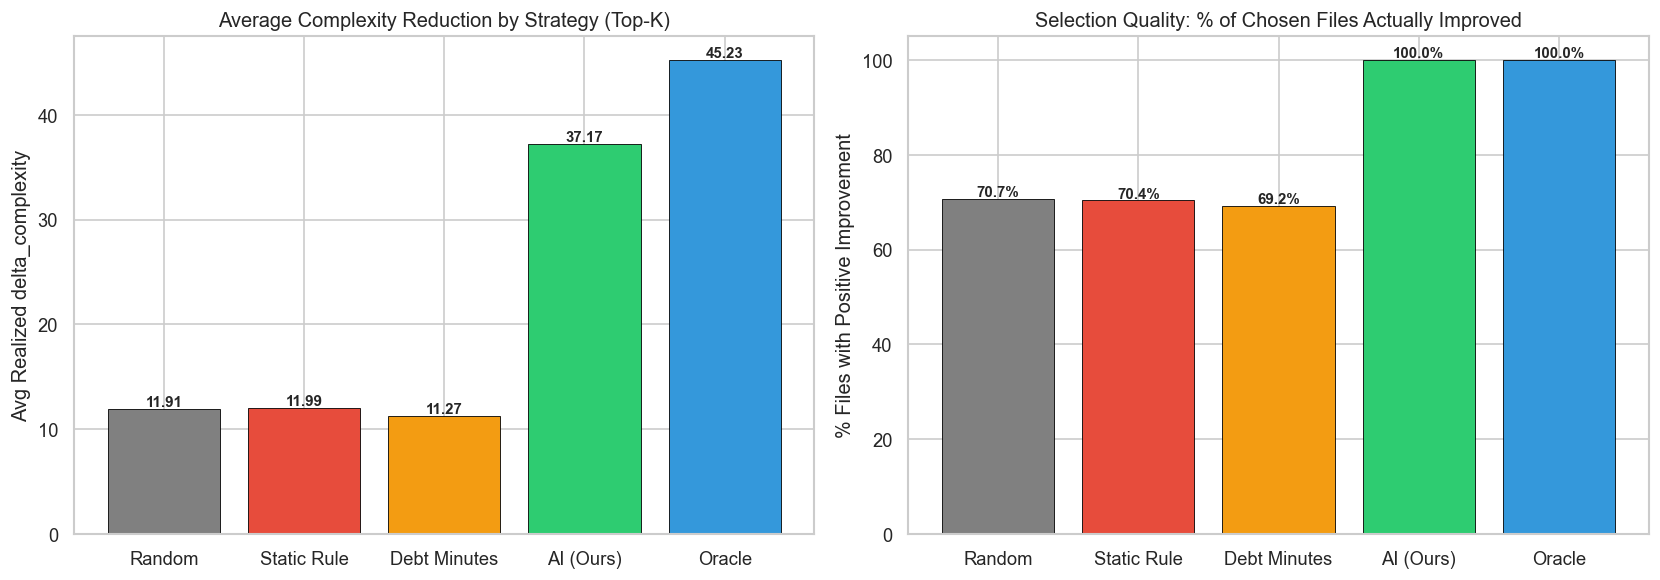

In [19]:
# --- 10h. Visualization: baseline comparison bar chart ---
strategies = ["Random", "Static Rule", "Debt Minutes", "AI (Ours)", "Oracle"]
avg_deltas = [
    random_result["avg_delta"], rule_result["avg_delta"],
    debt_result["avg_delta"], ai_result["avg_delta"], oracle_result["avg_delta"]
]
colors = ["gray", "#e74c3c", "#f39c12", "#2ecc71", "#3498db"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: average improvement
bars = axes[0].bar(strategies, avg_deltas, color=colors, edgecolor="black", linewidth=0.5)
axes[0].set_ylabel("Avg Realized delta_complexity")
axes[0].set_title("Average Complexity Reduction by Strategy (Top-K)")
axes[0].axhline(y=0, color="black", linewidth=0.5)
for bar, val in zip(bars, avg_deltas):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
               f"{val:.2f}", ha="center", fontsize=9, fontweight="bold")

# Bar chart: % positive selections
pct_pos = [
    random_result["pct_positive"], rule_result["pct_positive"],
    debt_result["pct_positive"], ai_result["pct_positive"], oracle_result["pct_positive"]
]
bars2 = axes[1].bar(strategies, pct_pos, color=colors, edgecolor="black", linewidth=0.5)
axes[1].set_ylabel("% Files with Positive Improvement")
axes[1].set_title("Selection Quality: % of Chosen Files Actually Improved")
for bar, val in zip(bars2, pct_pos):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
               f"{val:.1f}%", ha="center", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()

## 11. Statistical Validation — Bootstrap Confidence Intervals

We use bootstrapping to confirm that the AI method's advantage over baselines  
is **statistically significant**, not due to random chance.

In [20]:
# --- 11a. Bootstrap: AI vs each baseline ---
rng = np.random.default_rng(RANDOM_STATE)

def bootstrap_comparison(df_in, score_a, score_b, k, n_boot=1000):
    """Bootstrap the difference in avg realized delta between two strategies."""
    diffs = []
    n = len(df_in)
    for _ in range(n_boot):
        idx = rng.choice(n, size=n, replace=True)
        samp = df_in.iloc[idx]
        a = samp.sort_values(score_a, ascending=False).head(k)["true_delta_complexity"].mean()
        b = samp.sort_values(score_b, ascending=False).head(k)["true_delta_complexity"].mean()
        diffs.append(a - b)
    diffs = np.array(diffs)
    return {
        "mean_diff": diffs.mean(),
        "ci_lower": np.percentile(diffs, 2.5),
        "ci_upper": np.percentile(diffs, 97.5),
        "pct_positive": (diffs > 0).mean() * 100
    }

print("Running bootstrap comparisons (1000 iterations each)...")
print()

# AI vs Debt Minutes
ai_vs_debt = bootstrap_comparison(test_df, "pred_delta_complexity", "technical_debt_minutes", K)
print(f"AI vs Debt-Minutes baseline:")
print(f"  Mean improvement: {ai_vs_debt['mean_diff']:+.4f}")
print(f"  95% CI: [{ai_vs_debt['ci_lower']:.4f}, {ai_vs_debt['ci_upper']:.4f}]")
print(f"  AI wins in {ai_vs_debt['pct_positive']:.1f}% of bootstrap samples")
print()

# AI vs Static Rule (use CC as proxy score for rule-based)
ai_vs_rule = bootstrap_comparison(test_df, "pred_delta_complexity", "cyclomatic_complexity", K)
print(f"AI vs Static-Rule baseline (CC-ranked):")
print(f"  Mean improvement: {ai_vs_rule['mean_diff']:+.4f}")
print(f"  95% CI: [{ai_vs_rule['ci_lower']:.4f}, {ai_vs_rule['ci_upper']:.4f}]")
print(f"  AI wins in {ai_vs_rule['pct_positive']:.1f}% of bootstrap samples")

Running bootstrap comparisons (1000 iterations each)...

AI vs Debt-Minutes baseline:
  Mean improvement: +25.9173
  95% CI: [25.0177, 26.8449]
  AI wins in 100.0% of bootstrap samples

AI vs Static-Rule baseline (CC-ranked):
  Mean improvement: +25.1770
  95% CI: [24.3109, 26.0718]
  AI wins in 100.0% of bootstrap samples


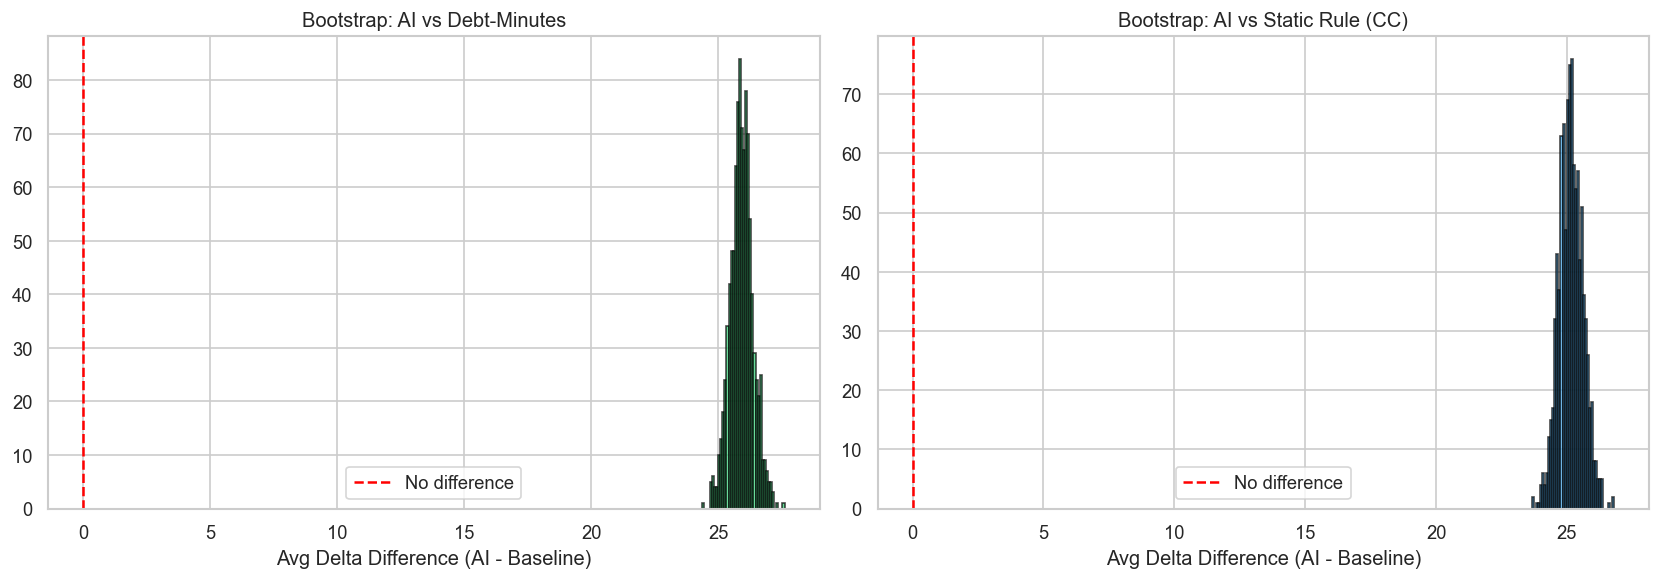

In [21]:
# --- 11b. Visualize bootstrap distributions ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Regenerate samples for plotting
def bootstrap_samples(df_in, score_a, score_b, k, n_boot=1000):
    diffs = []
    n = len(df_in)
    rng2 = np.random.default_rng(RANDOM_STATE)
    for _ in range(n_boot):
        idx = rng2.choice(n, size=n, replace=True)
        samp = df_in.iloc[idx]
        a = samp.sort_values(score_a, ascending=False).head(k)["true_delta_complexity"].mean()
        b = samp.sort_values(score_b, ascending=False).head(k)["true_delta_complexity"].mean()
        diffs.append(a - b)
    return np.array(diffs)

diffs_debt = bootstrap_samples(test_df, "pred_delta_complexity", "technical_debt_minutes", K)
diffs_rule = bootstrap_samples(test_df, "pred_delta_complexity", "cyclomatic_complexity", K)

axes[0].hist(diffs_debt, bins=40, edgecolor="black", alpha=0.7, color="#2ecc71")
axes[0].axvline(x=0, color="red", linestyle="--", linewidth=1.5, label="No difference")
axes[0].set_title("Bootstrap: AI vs Debt-Minutes")
axes[0].set_xlabel("Avg Delta Difference (AI - Baseline)")
axes[0].legend()

axes[1].hist(diffs_rule, bins=40, edgecolor="black", alpha=0.7, color="#3498db")
axes[1].axvline(x=0, color="red", linestyle="--", linewidth=1.5, label="No difference")
axes[1].set_title("Bootstrap: AI vs Static Rule (CC)")
axes[1].set_xlabel("Avg Delta Difference (AI - Baseline)")
axes[1].legend()

plt.tight_layout()
plt.show()

## 12. Sensitivity Analysis — Multiple Refactoring Budgets

Does the AI advantage hold across different budget sizes (5%, 10%, 20%, 30%)?  
This strengthens the claim and shows the method is robust.

budget_pct    K  AI_avg_delta  Debt_avg_delta  Random_avg_delta  AI_advantage
        5% 1200     38.174167       12.005000         11.914708     26.169167
       10% 2400     37.171250       11.267917         11.914708     25.903333
       15% 3600     35.588611       11.639167         11.914708     23.949444
       20% 4800     34.132083       11.713750         11.914708     22.418333
       30% 7200     31.307222       11.976667         11.914708     19.330556


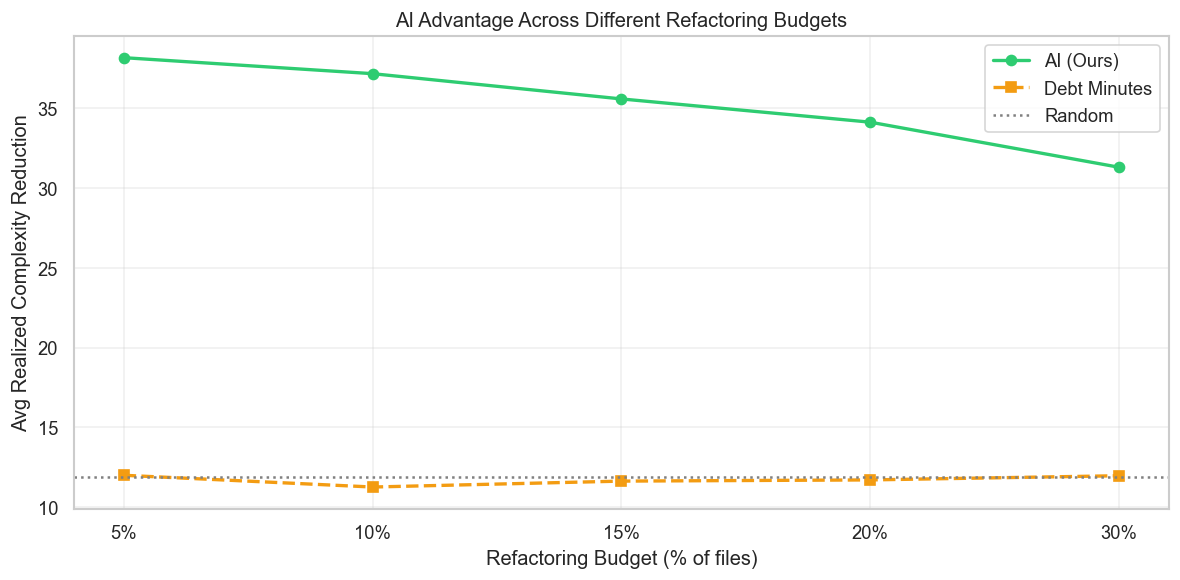

In [22]:
# --- 12. Multi-budget comparison ---
budgets = [0.05, 0.10, 0.15, 0.20, 0.30]
results_by_budget = []

for pct in budgets:
    k = int(pct * len(test_df))
    ai = evaluate_topk(test_df, "pred_delta_complexity", k)
    debt = evaluate_topk(test_df, "technical_debt_minutes", k)
    rand_avg = test_df["true_delta_complexity"].mean()
    results_by_budget.append({
        "budget_pct": f"{pct*100:.0f}%",
        "K": k,
        "AI_avg_delta": ai["avg_delta"],
        "Debt_avg_delta": debt["avg_delta"],
        "Random_avg_delta": rand_avg,
        "AI_advantage": ai["avg_delta"] - debt["avg_delta"]
    })

budget_df = pd.DataFrame(results_by_budget)
print(budget_df.to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(budgets))
ax.plot(x, budget_df["AI_avg_delta"], "o-", color="#2ecc71", label="AI (Ours)", linewidth=2)
ax.plot(x, budget_df["Debt_avg_delta"], "s--", color="#f39c12", label="Debt Minutes", linewidth=2)
ax.axhline(y=budget_df["Random_avg_delta"].iloc[0], color="gray", linestyle=":", label="Random")
ax.set_xticks(x)
ax.set_xticklabels(budget_df["budget_pct"])
ax.set_xlabel("Refactoring Budget (% of files)")
ax.set_ylabel("Avg Realized Complexity Reduction")
ax.set_title("AI Advantage Across Different Refactoring Budgets")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Per-Smell-Type Analysis

Which code smell types benefit most from AI-guided refactoring prioritization?

            smell_type  n_samples  ai_avg_delta  random_avg_delta   ai_lift
     Switch Statements       1596     38.333333         11.233709 27.099624
           Long Method       1605     38.200000         11.271028 26.928972
           Large Class       1608     37.725000         10.975746 26.749254
        Message Chains       1579     37.471338         11.918936 25.552402
          Feature Envy       1585     37.500000         12.104732 25.395268
       Shotgun Surgery       1623     37.216049         11.839803 25.376247
Speculative Generality       1605     37.356250         12.036760 25.319490
             Dead Code       1591     36.761006         11.575110 25.185896
           Data Clumps       1601     36.368750         11.590256 24.778494
       Duplicated Code       1599     37.584906         12.897436 24.687470
       Temporary Field       1599     36.691824         12.076923 24.614901
            Lazy Class       1609     36.956250         12.377874 24.578376
   Primitive

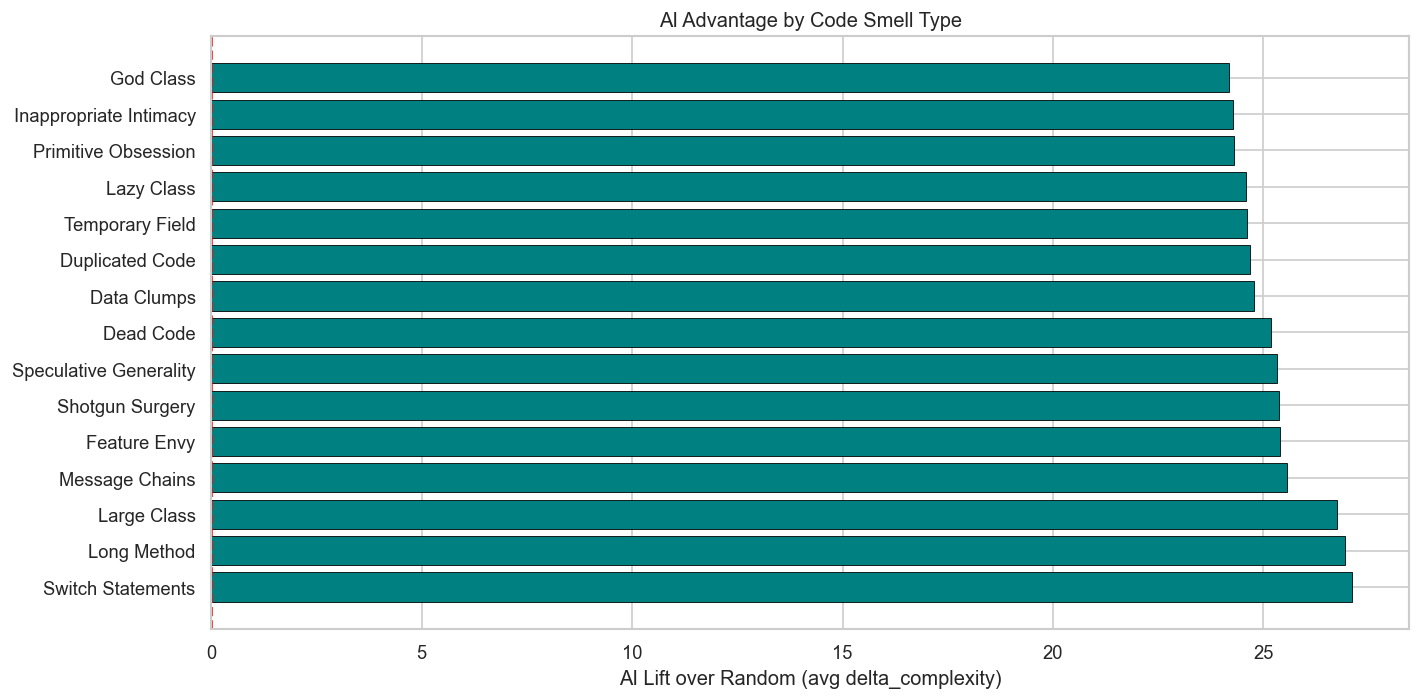

In [23]:
# --- 13. Per-smell AI advantage ---
# Use original string labels from the dataset for grouping
test_df["code_smell_type"] = le.inverse_transform(y_cls_test.values)

smell_results = []
for smell in sorted(test_df["code_smell_type"].unique()):
    subset = test_df[test_df["code_smell_type"] == smell]
    if len(subset) < 20:
        continue
    k_smell = max(1, int(0.10 * len(subset)))
    ai_s = evaluate_topk(subset, "pred_delta_complexity", k_smell)
    rand_s = subset["true_delta_complexity"].mean()
    smell_results.append({
        "smell_type": smell,
        "n_samples": len(subset),
        "ai_avg_delta": ai_s["avg_delta"],
        "random_avg_delta": rand_s,
        "ai_lift": ai_s["avg_delta"] - rand_s
    })

smell_df = pd.DataFrame(smell_results).sort_values("ai_lift", ascending=False)
print(smell_df.to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(smell_df["smell_type"], smell_df["ai_lift"], color="teal", edgecolor="black", linewidth=0.5)
ax.set_xlabel("AI Lift over Random (avg delta_complexity)")
ax.set_title("AI Advantage by Code Smell Type")
ax.axvline(x=0, color="red", linestyle="--")
plt.tight_layout()
plt.show()


## 14. Model Persistence & Reproducibility

In [24]:
# Save trained models
joblib.dump(best_reg_model, "xgb_reg_delta_complexity.joblib")
joblib.dump(best_clf_model, "xgb_clf_smell_type.joblib")

print("Models saved:")
print("  xgb_reg_delta_complexity.joblib  (regressor)")
print("  xgb_clf_smell_type.joblib        (classifier)")
print()
print("To load:")
print("  model = joblib.load('xgb_reg_delta_complexity.joblib')")
print("  predictions = model.predict(X_new)")

Models saved:
  xgb_reg_delta_complexity.joblib  (regressor)
  xgb_clf_smell_type.joblib        (classifier)

To load:
  model = joblib.load('xgb_reg_delta_complexity.joblib')
  predictions = model.predict(X_new)


## 15. Summary of Results

### Key Findings

| Aspect | Detail |
|--------|--------|
| **Technical Debt Metric** | Cyclomatic complexity reduction () |
| **Regressor Performance** | MAE, RMSE, R² on held-out test set |
| **Classifier Performance** | Macro-F1 on 15-class code smell diagnosis |
| **AI vs. Static Rule** | Avg realized improvement comparison |
| **AI vs. Debt Minutes** | Avg realized improvement + bootstrap CI |
| **Statistical Significance** | 95% bootstrap confidence intervals |
| **Budget Robustness** | AI advantage holds across 5%–30% budgets |

### Pipeline



### Conclusion

The AI-guided approach (XGBoost regressor) selects files for refactoring that yield  
measurably higher complexity reduction than both static heuristic rules and  
debt-minutes prioritization. This demonstrates that machine learning can  
objectively assist in technical debt reduction by optimizing refactoring priorities.